## Parameter estimation for a linear operator using Gaussian processes


Assumptions about the linear operator:

$\mathcal{L}_x^\phi u(x) = f(x)$

$u(x) \sim \mathcal{GP}(0, k_{uu}(x,x',\theta))$

$f(x) \sim \mathcal{GP}(0, k_{ff}(x,x',\theta,\phi))$

$y_u = u(X_u) + \epsilon_u; \epsilon_u \sim \mathcal{N}(0, \sigma_u^2I)$

$y_f = f(X_f) + \epsilon_f; \epsilon_f \sim \mathcal{N}(0, \sigma_f^2I)$

Taking a simple operator as example:

$\mathcal{L}_x^\phi := \phi \cdot + \frac{d}{dx_1}\cdot + \frac{d^2}{dx_2^2}\cdot$

$u(x) = x_1 x_2 - x_2^2$

$f(x) = \phi x_1 x_2 - \phi x_2^2 + x_2 - 2$

Problem at hand:

Given $\{X_u, y_u\}$ and $\{X_f, y_f\}$, estimate $\phi$.


#### Simulate data


Use $\phi = 2$


In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
def get_simulated_data(n, phi):
    x = np.random.rand(n,2)
    y_u = np.multiply(x[:,0], x[:,1]) - x[:,1]**2
    y_f = phi*y_u + x[:,1] - 2
    return (x, y_u, y_f)

#### Evaluate kernels



This step uses information about $\mathcal{L}_x^\phi$ but not about $u(x)$ or $f(x)$.

$k_{uu}(x_i, x_j; \theta) =  exp(-\theta_1(x_{i,1}-x_{j,1})^2 -\theta_2(x_{i,2}-x_{j,2})^2)$


In [3]:
xi1, xj1, xi2, xj2, theta1, theta2, phi = sp.symbols('xi1 xj1 xi2 xj2 theta1 theta2 phi')
kuu_sym = sp.exp(-theta1*((xi1 - xj1)**2) - theta2*((xi2 - xj2)**2))
kuu_fn = sp.lambdify((xi1, xj1, xi2, xj2, theta1, theta2), kuu_sym, "numpy")
def kuu(x, theta1, theta2):
    k = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            k[i,j] = kuu_fn(x[i,0], x[j,0], x[i,1], x[j,1], theta1, theta2)
    return k

$k_{ff}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\phi \mathcal{L}_{x_j}^\phi k_{uu}(x_i, x_j; \theta) \\
= \mathcal{L}_{x_i}^\phi \left( \phi k_{uu} + \frac{\partial}{\partial x_{j,1}}k_{uu} + \frac{\partial^2}{\partial^2 x_{j,2}}k_{uu}\right) \\
= \phi^2 k_{uu} + \phi \frac{\partial}{\partial x_{j,1}}k_{uu} + \phi \frac{\partial^2}{\partial^2 x_{j,2}}k_{uu} + \phi \frac{\partial}{\partial x_{i,1}}k_{uu} + \frac{\partial}{\partial x_{i,1}}\frac{\partial}{\partial x_{j,1}}k_{uu} + \frac{\partial}{\partial x_{i,1}}\frac{\partial^2}{\partial^2 x_{j,2}}k_{uu} + \phi \frac{\partial^2}{\partial^2 x_{i,2}}k_{uu} + \frac{\partial^2}{\partial^2 x_{i,2}}\frac{\partial}{\partial x_{j,1}}k_{uu} + \frac{\partial^2}{\partial^2 x_{i,2}}\frac{\partial^2}{\partial^2 x_{j,2}}k_{uu}$

In [4]:
kff_sym = phi**2*kuu_sym \
            + phi*sp.diff(kuu_sym, xj1) \
            + phi*sp.diff(kuu_sym, xj2, xj2) \
            + phi*sp.diff(kuu_sym, xi1) \
            + sp.diff(kuu_sym, xj1, xi1) \
            + sp.diff(kuu_sym, xj2, xj2, xi1) \
            + phi*sp.diff(kuu_sym, xi2, xi2) \
            + sp.diff(kuu_sym, xj1, xi2, xi2) \
            + sp.diff(kuu_sym, xj2, xj2, xi2, xi2)
kff_fn = sp.lambdify((xi1, xj1, xi2, xj2, theta1, theta2, phi), kff_sym, "numpy")
def kff(x, theta1, theta2, phi):
    k = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            k[i,j] = kff_fn(x[i,0], x[j,0], x[i,1], x[j,1], theta1, theta2, phi)
    return k

$k_{fu}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\phi k_{uu}(x_i, x_j; \theta) \\
= \phi k_{uu} + \frac{\partial}{\partial x_{i,1}}k_{uu} + \frac{\partial^2}{\partial x_{i,2}^2}k_{uu}$

In [5]:
kfu_sym = phi*kuu_sym + sp.diff(kuu_sym, xi1) + sp.diff(kuu_sym, xi2, xi2)
kfu_fn = sp.lambdify((xi1, xj1, xi2, xj2, theta1, theta2, phi), kfu_sym, "numpy")
def kfu(x, theta1, theta2, phi):
    k = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            k[i,j] = kfu_fn(x[i,0], x[j,0], x[i,1], x[j,1], theta1, theta2, phi)
    return k

In [6]:
def kuf(x, theta1, theta2, phi):
    return kfu(x, theta1, theta2, phi).T

#### Define negative log marginal likelihood  



$K = \begin{bmatrix}
k_{uu}(X_u, X_u; \theta) + \sigma_u^2I & k_{uf}(X_u, X_f; \theta, \phi) \\
k_{fu}(X_f, X_u; \theta, \phi) & k_{ff}(X_f, X_f; \theta, \phi) + \sigma_f^2I
\end{bmatrix}$

For simplicity, assume $\sigma_u = \sigma_f$.

$\mathcal{NLML} = \frac{1}{2} \left[ log|K| + y^TK^{-1}y + Nlog(2\pi) \right]$

where $y = \begin{bmatrix}
y_u \\
y_f
\end{bmatrix}$

In [7]:
def nlml(params, x, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [
            kuu(x, params[0], params[1]) + s*np.identity(x.shape[0]),
            kuf(x, params[0], params[1], params[2])
        ],
        [
            kfu(x, params[0], params[1], params[2]),
            kff(x, params[0], params[1], params[2]) + s*np.identity(x.shape[0])
        ]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) \
               + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [8]:
(x, yu, yf) = get_simulated_data(10, 2)
nlml((1, 1, 0.69), x, yu, yf, 1e-6)

1.8858815562032323

#### Optimise hyperparameters


In [9]:
nlml_wp = lambda params: nlml(params, x, yu, yf, 1e-7)
m = minimize(nlml_wp, np.random.rand(3), method="Nelder-Mead")

In [10]:
m

 final_simplex: (array([[-2.41079587, -0.45092541,  0.76150154],
       [-2.41081496, -0.45092082,  0.7614958 ],
       [-2.41083248, -0.45094797,  0.76150226],
       [-2.41071051, -0.45096978,  0.76149467]]), array([-40.26873911, -40.2687391 , -40.2687391 , -40.26873909]))
           fun: -40.26873911246755
       message: 'Optimization terminated successfully.'
          nfev: 247
           nit: 138
        status: 0
       success: True
             x: array([-2.41079587, -0.45092541,  0.76150154])

In [11]:
np.exp(m.x)

array([0.08974384, 0.63703835, 2.14148933])

#### Analysis

In [12]:
n_range = np.arange(5, 50)
plot_data = []
for i in range(n_range.size):
    (x, y1, y2) = get_simulated_data(n_range[i], 2)
    nlml_wp = lambda params: nlml(params, x, y1, y2, 1e-7)
    m = minimize(nlml_wp, np.random.rand(3), method="Nelder-Mead")
    plot_data.append(np.array([m.nfev, m.nit, np.exp(m.x[2])]))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/site-packages/scipy/optimize/optimize.py:563: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


In [13]:
x = np.reshape(plot_data, (n_range.size,3))

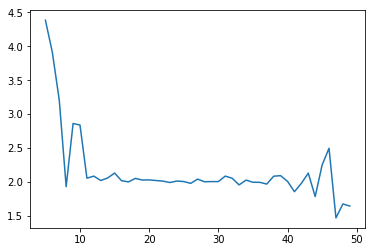

In [14]:
plt.plot(n_range, x[:,2])
plt.show()